In [140]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import log_reg_tensorflow as lrf
import ann_tensorflow as anntf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv("mnist_dataset/train.csv")

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = df[['pixel{}'.format(i) for i in range(784)]].values.astype(np.float32)
mu = X.mean(axis=0)
std = X.std(axis=0)
np.place(std, std == 0, 1)
X_train, X_test, y_train, y_test = train_test_split((X-mu)/std, 
                                                    df['label'].values.astype(np.int32), test_size=0.2, random_state=42)

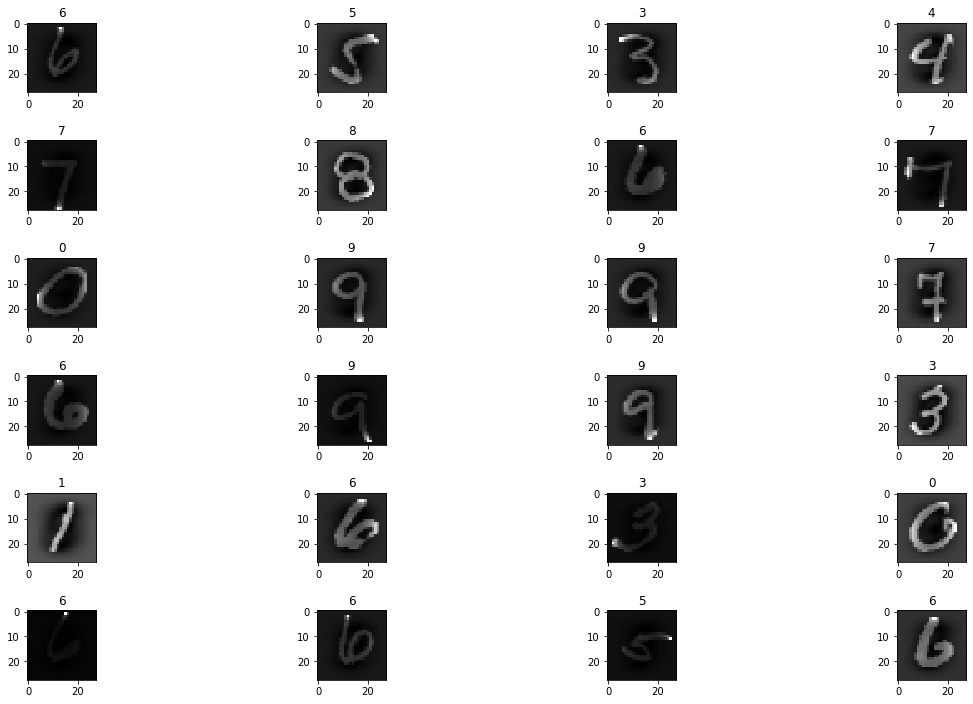

In [76]:
imageside = 28
cols = 4
rows = 6
f, axarr = plt.subplots(rows,cols,figsize=(18,10))
for i in range(rows):
    for j in range(cols):
        axarr[i,j].imshow(X_train[cols*i+j].reshape(imageside,imageside), cmap='gray')
        axarr[i,j].set_title(y_train[cols*i+j])

f.tight_layout(pad=1.5)

In [169]:
importlib.reload(lrf)

<module 'log_reg_tensorflow' from '/home/caio/Desktop/dsutils/DeepLearning/log_reg_tensorflow.py'>

In [90]:
tf.reset_default_graph() #important otherwise get errors - boilerplate
logreg = lrf.MulticlassLogisticRegression(num_epochs=100,
                                          print_epoch=100,
                                          learning_rate=2e-3,
                                          gd_type='batch', #gradient descent type
                                          mu = 0.9, #momentum parameter mu
                                          decay = 0.99 #decay rate of RMSProp
                                         )
logreg.fit(X_train, y_train)

epoch:  0 cost:  31341.174 accuracy:  0.7150595238095238
epoch:  10 cost:  7125.9336 accuracy:  0.940327380952381
epoch:  20 cost:  6492.585 accuracy:  0.9447321428571429
epoch:  30 cost:  6125.475 accuracy:  0.9479761904761905
epoch:  40 cost:  6255.2617 accuracy:  0.9459821428571429
epoch:  50 cost:  5955.7505 accuracy:  0.9493154761904762
epoch:  60 cost:  5916.305 accuracy:  0.94875
epoch:  70 cost:  5808.0444 accuracy:  0.9494940476190477
epoch:  80 cost:  6014.0293 accuracy:  0.9474702380952381
epoch:  90 cost:  5779.351 accuracy:  0.9489880952380952


In [91]:
print("Model accuracy on training set: {}\n".format(round(logreg.score(y_train, logreg.predict(X_train)),4))+
      "Model accuracy on test set: {}".format(logreg.score(y_test, logreg.predict(X_test))))

INFO:tensorflow:Restoring parameters from ./model/logreg_model-1000
INFO:tensorflow:Restoring parameters from ./model/logreg_model-1000
Model accuracy on training set: 0.951
Model accuracy on test set: 0.9025


Wow! Have a look! Neural nets are really prone to overfitting! It's just insane, it was able to completely learn everything about this data.

In [135]:
nn = anntf.ANNClassifier(hidden_layers_sizes=[300],
                       activation='relu',
                       num_epochs=10,
                       print_epoch=20,
                       learning_rate=1e-4,
                       gd_type='batch',
                       batch_number=30,
                       eps=1e-8, 
                       mu=0.9 
                      )
nn.fit(X_train, y_train, X_test, y_test)

epoch: 0 cost: 2.342 accuracy: 0.125 cost_test: 2.342 accuracy_test: 0.129
epoch: 0 cost: 0.340 accuracy: 0.902 cost_test: 0.353 accuracy_test: 0.894
epoch: 1 cost: 0.227 accuracy: 0.933 cost_test: 0.261 accuracy_test: 0.924
epoch: 2 cost: 0.177 accuracy: 0.949 cost_test: 0.218 accuracy_test: 0.938
epoch: 2 cost: 0.149 accuracy: 0.958 cost_test: 0.194 accuracy_test: 0.946
epoch: 3 cost: 0.129 accuracy: 0.964 cost_test: 0.176 accuracy_test: 0.951
epoch: 4 cost: 0.113 accuracy: 0.969 cost_test: 0.166 accuracy_test: 0.953
epoch: 4 cost: 0.100 accuracy: 0.973 cost_test: 0.156 accuracy_test: 0.957
epoch: 5 cost: 0.089 accuracy: 0.976 cost_test: 0.148 accuracy_test: 0.959
epoch: 6 cost: 0.078 accuracy: 0.979 cost_test: 0.142 accuracy_test: 0.961
epoch: 6 cost: 0.069 accuracy: 0.983 cost_test: 0.136 accuracy_test: 0.962
epoch: 7 cost: 0.062 accuracy: 0.985 cost_test: 0.133 accuracy_test: 0.962
epoch: 8 cost: 0.054 accuracy: 0.987 cost_test: 0.126 accuracy_test: 0.965
epoch: 8 cost: 0.048 accu

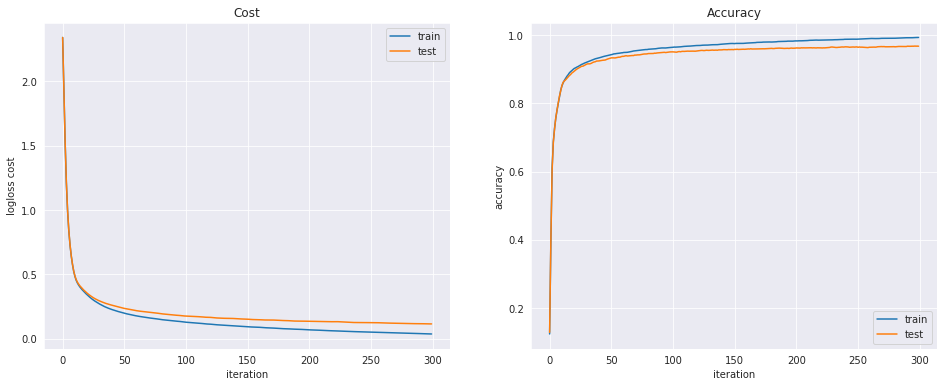

In [165]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

#logloss
ax1.plot(list(range(len(nn.costs))),nn.costs)
ax1.plot(nn.costs_test)
ax1.set_title('Cost')
ax1.legend(['train','test'])
ax1.set_ylabel('logloss cost')
ax1.set_xlabel('iteration')

#accuracy
ax2.plot(nn.clf_rates)
ax2.plot(nn.clf_rates_test)
ax2.legend(['train','test'])
ax2.set_title('Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('iteration')
plt.show()

In [142]:
print("Model accuracy on training set: {}\n".format(round(nn.score(y_train, nn.predict(X_train)),4))+
      "Model accuracy on test set: {}".format(nn.score(y_test, nn.predict(X_test))))

INFO:tensorflow:Restoring parameters from ./model_ann/ann-300
INFO:tensorflow:Restoring parameters from ./model_ann/ann-300
Model accuracy on training set: 0.9927
Model accuracy on test set: 0.9671428571428572


In [175]:
importlib.reload(anntf)

<module 'ann_tensorflow' from '/home/caio/Desktop/dsutils/DeepLearning/ann_tensorflow.py'>

Dropout regularization:

In [176]:
nn = anntf.ANNClassifier(hidden_layers_sizes=[300],
                         dropout_rates=[0.8,0.5], #dropout regularization
                         activation='relu',
                         num_epochs=10,
                         print_epoch=20,
                         learning_rate=1e-4,
                         gd_type='batch',
                         batch_number=30,
                         eps=1e-8, 
                         mu=0.9)
nn.fit(X_train, y_train, X_test, y_test)

epoch: 0 cost: 2.388 accuracy: 0.172 cost_test: 2.388 accuracy_test: 0.178
epoch: 0 cost: 1.422 accuracy: 0.879 cost_test: 1.434 accuracy_test: 0.873
epoch: 1 cost: 1.347 accuracy: 0.911 cost_test: 1.375 accuracy_test: 0.906
epoch: 2 cost: 1.324 accuracy: 0.929 cost_test: 1.326 accuracy_test: 0.921
epoch: 2 cost: 1.299 accuracy: 0.940 cost_test: 1.313 accuracy_test: 0.931
epoch: 3 cost: 1.286 accuracy: 0.946 cost_test: 1.301 accuracy_test: 0.935
epoch: 4 cost: 1.277 accuracy: 0.953 cost_test: 1.294 accuracy_test: 0.940
epoch: 4 cost: 1.259 accuracy: 0.956 cost_test: 1.275 accuracy_test: 0.942
epoch: 5 cost: 1.274 accuracy: 0.958 cost_test: 1.288 accuracy_test: 0.944
epoch: 6 cost: 1.259 accuracy: 0.961 cost_test: 1.266 accuracy_test: 0.946
epoch: 6 cost: 1.255 accuracy: 0.963 cost_test: 1.295 accuracy_test: 0.948
epoch: 7 cost: 1.236 accuracy: 0.965 cost_test: 1.284 accuracy_test: 0.950
epoch: 8 cost: 1.232 accuracy: 0.967 cost_test: 1.265 accuracy_test: 0.951
epoch: 8 cost: 1.229 accu

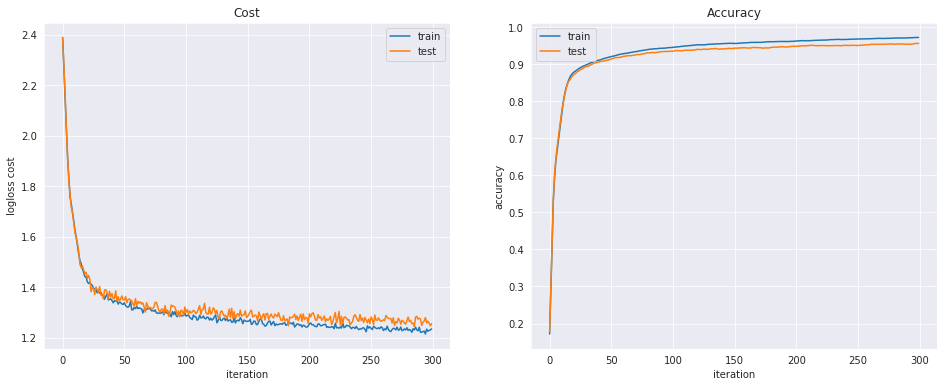

In [177]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

#logloss
ax1.plot(list(range(len(nn.costs))),nn.costs)
ax1.plot(nn.costs_test)
ax1.set_title('Cost')
ax1.legend(['train','test'])
ax1.set_ylabel('logloss cost')
ax1.set_xlabel('iteration')

#accuracy
ax2.plot(nn.clf_rates)
ax2.plot(nn.clf_rates_test)
ax2.legend(['train','test'])
ax2.set_title('Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('iteration')
plt.show()

In [178]:
print("Model accuracy on training set: {}\n".format(round(nn.score(y_train, nn.predict(X_train)),4))+
      "Model accuracy on test set: {}".format(nn.score(y_test, nn.predict(X_test))))

INFO:tensorflow:Restoring parameters from ./model_ann/ann-300
INFO:tensorflow:Restoring parameters from ./model_ann/ann-300
Model accuracy on training set: 0.9722
Model accuracy on test set: 0.9561904761904761


A bit lower performance, there's also more instability in the training curve.